# Indicator of heavy rainfall

## SPI approach

The SPI can also be used as an indicator of heavy rainfall periods (REF)

The choice of time period over which to calculate SPI is still open.

Can use SPI > 2 as indicator of heavy rain period 

# TODO extract details on how rainfall events were done

Chapter 2
Analyzing Extreme Events Using Standardized Precipitation Index During the 20th Century for Surat District, India


## Return value approach

> Previous editions looked at the 10-year return value for (daily?) rainfall. Doing this would mean getting daily data from ERA which is a pain. Possibly this could be done monthly instead. In the end it's not that dissimilar to SPI threshold (calculating how likely the event it)


In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook


import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [3]:
POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

### Comparing files

- note that because ERA covers sea and CRU does not, taking average over globe is not going to give a good comparison

In [4]:
cru_spi6 = xr.open_dataarray(DATA_SRC / 'lancet' / 'spi6_1901_2016_cru.nc', 
                             chunks={'time': 12}
                            )

In [5]:
era_spi6 = xr.open_dataarray(DATA_SRC / 'lancet' / 'spi6_1980_2017_era.nc', 
                             chunks={'time': 12}
                            )

In [16]:
cru_ts = cru_spi6.mean(dim=['lon', 'lat']).compute()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:
era_ts = era_spi6.mean(dim=['longitude', 'latitude']).compute()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


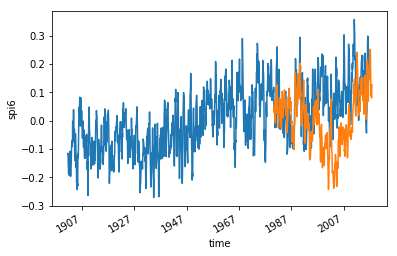

In [18]:
cru_ts.plot()
era_ts.plot()